In [49]:
# for data manipulation
import pandas as pd
import numpy as np

#for graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#models to run
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import cross_val_score

#train_test_split
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, GridSearchCV

#metrics
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score

In [13]:
# read raw data
raw_data = pd.read_csv('/home/sourabh/Downloads/kddcup.data_10_percent1.csv')

In [14]:
raw_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1,0,0.11,0,0,0,0,0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1,0,0.05,0,0,0,0,0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1,0,0.03,0,0,0,0,0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1,0,0.03,0,0,0,0,0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1,0,0.02,0,0,0,0,0,normal.


In [15]:
raw_data.shape

(494020, 42)

In [16]:
# remove ". " from labels
raw_data['label'] = raw_data['label'].apply(lambda x: x[:-1])

In [17]:
raw_data = raw_data.drop_duplicates()
raw_data.shape

(145585, 42)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

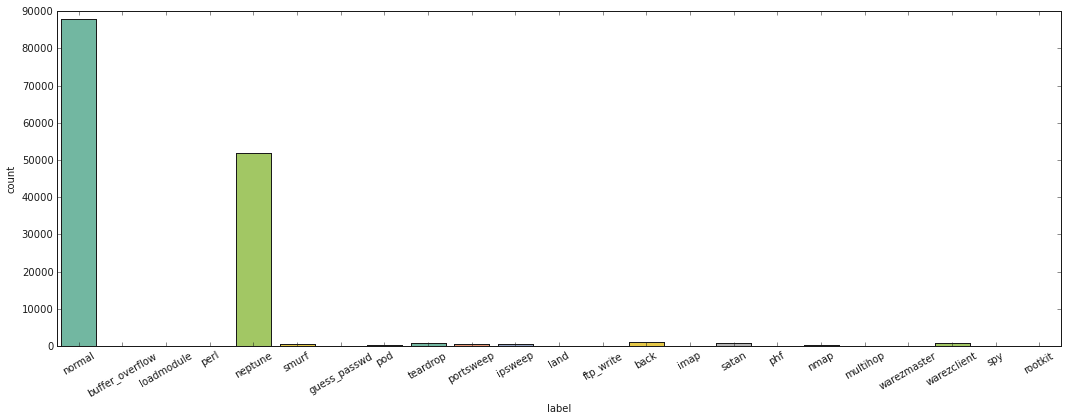

In [18]:
# distribution of labels
sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label', data = raw_data,palette="Set2", ax = ax1)
plt.xticks(rotation=30)

In [19]:
# combining labels as normal and attack
# normal is 1 , attack is 0

def get_label_grouping(label):
    if label == 'normal':
        return 'normal'
    else:
        return 'attack'

raw_data['label_attack_type']= raw_data['label'].apply(get_label_grouping)
# print(unique_df['label_attack_type'].head())
raw_data['label_attack_type'].value_counts()

normal    87831
attack    57754
dtype: int64

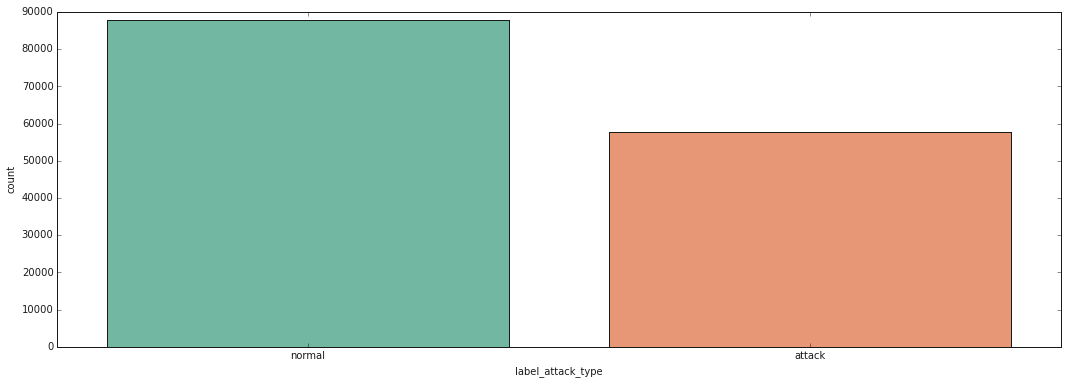

In [20]:
# distribution of label_attack_type

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label_attack_type', data = raw_data,palette="Set2", ax = ax1)
# plt.xticks(rotation=30)

In [21]:
raw_data.columns

Index([u'duration', u'protocol_type', u'service', u'flag', u'src_bytes',
       u'dst_bytes', u'land', u'wrong_fragment', u'urgent', u'hot',
       u'num_failed_logins', u'logged_in', u'num_compromised', u'root_shell',
       u'su_attempted', u'num_root', u'num_file_creations', u'num_shells',
       u'num_access_files', u'num_outbound_cmds', u'is_host_login',
       u'is_guest_login', u'count', u'srv_count', u'serror_rate',
       u'srv_serror_rate', u'rerror_rate', u'srv_rerror_rate',
       u'same_srv_rate', u'diff_srv_rate', u'srv_diff_host_rate',
       u'dst_host_count', u'dst_host_srv_count', u'dst_host_same_srv_rate',
       u'dst_host_diff_srv_rate', u'dst_host_same_src_port_rate',
       u'dst_host_srv_diff_host_rate', u'dst_host_serror_rate',
       u'dst_host_srv_serror_rate', u'dst_host_rerror_rate',
       u'dst_host_srv_rerror_rate', u'label', u'label_attack_type'],
      dtype='object')

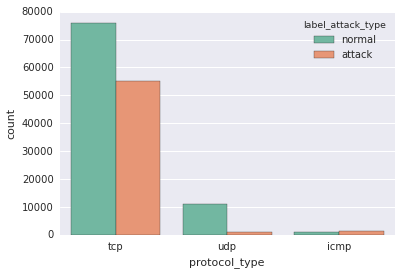

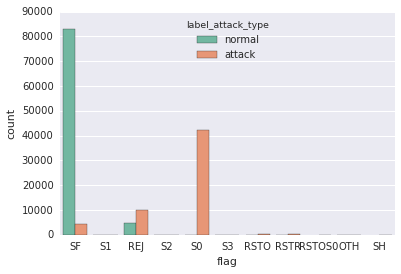

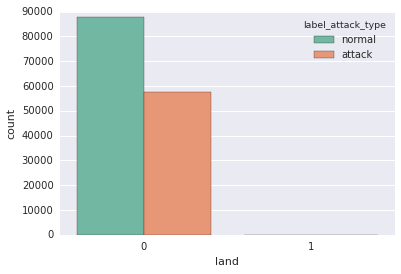

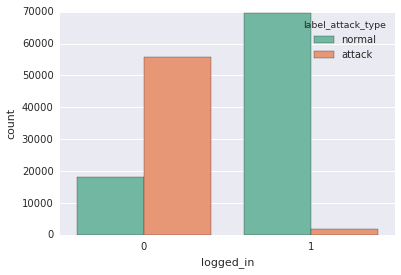

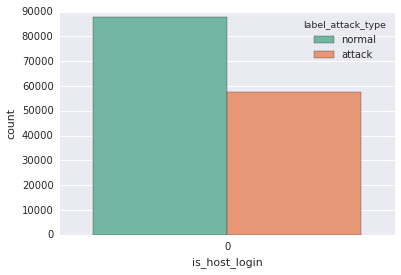

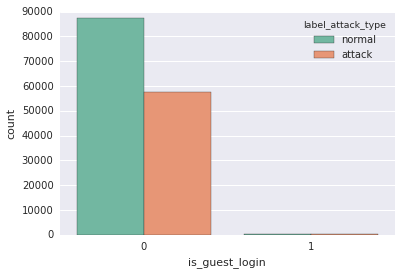

In [22]:
# distribution of categorical variables with 'label_attack_type'

sns.set()

categorical_cols = ['protocol_type','flag','land','logged_in','is_host_login','is_guest_login']

for column in categorical_cols:
    plt.figure()
    sns.countplot(x=column, hue="label_attack_type",data=raw_data, palette="Set2")

/home/sourabh/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


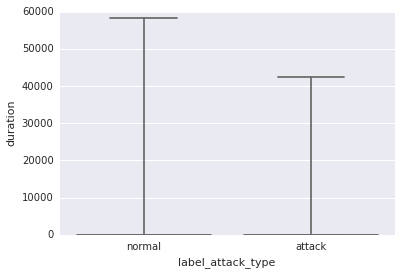

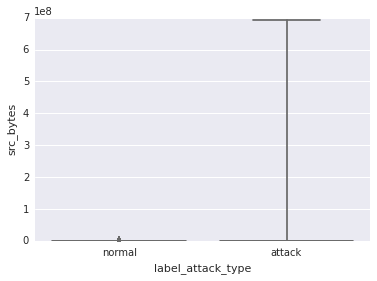

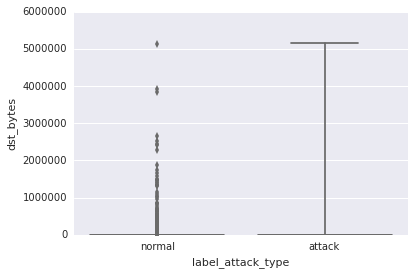

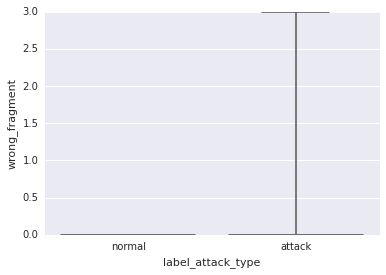

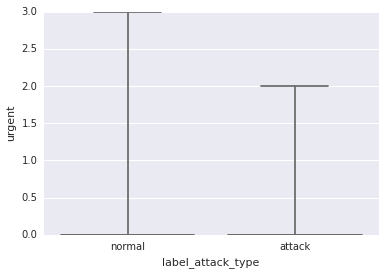

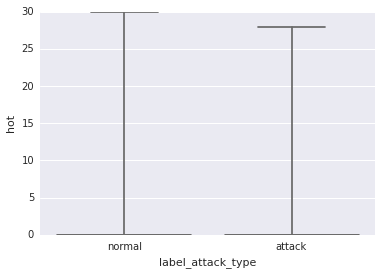

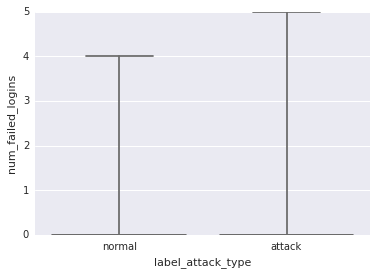

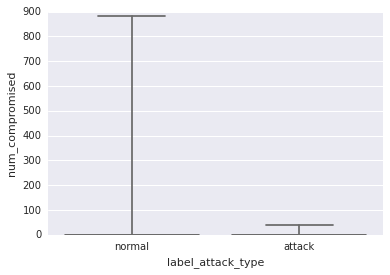

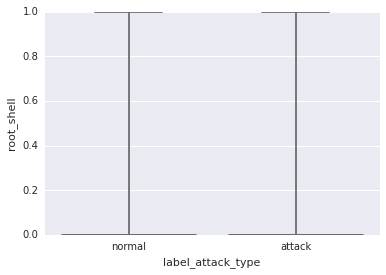

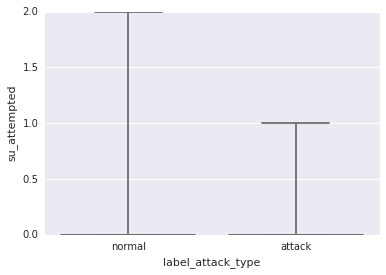

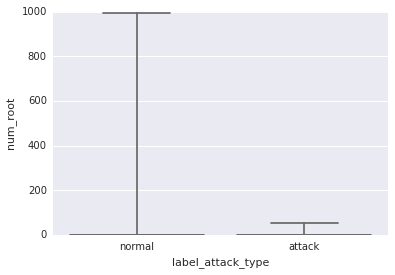

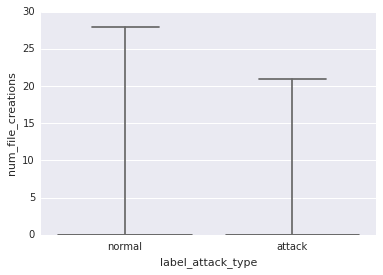

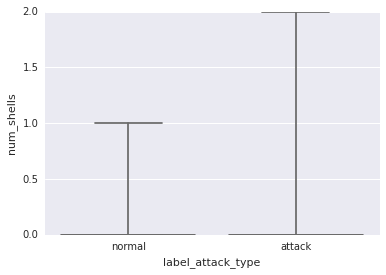

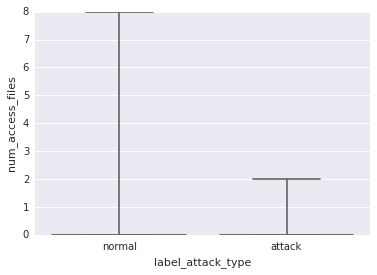

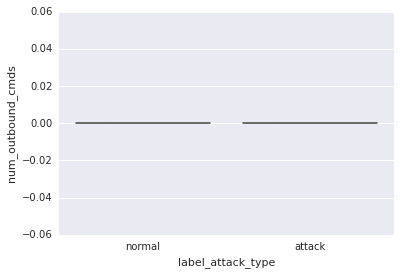

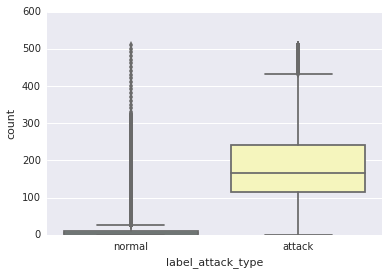

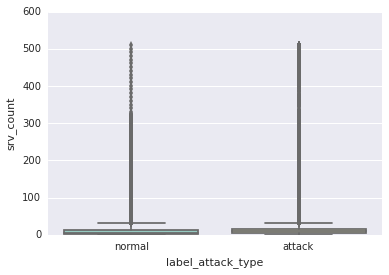

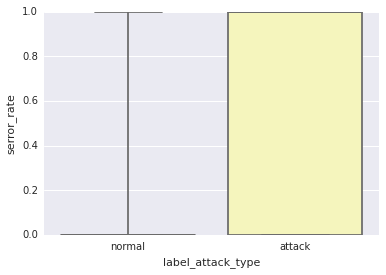

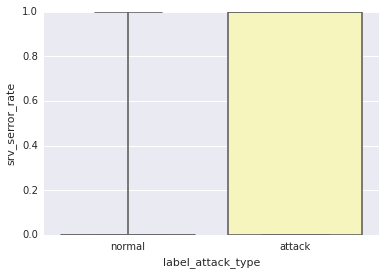

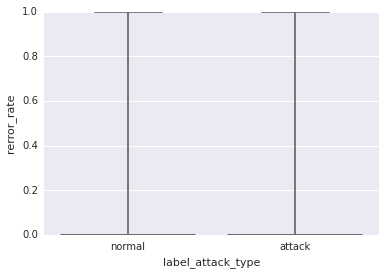

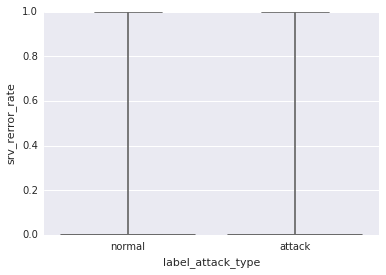

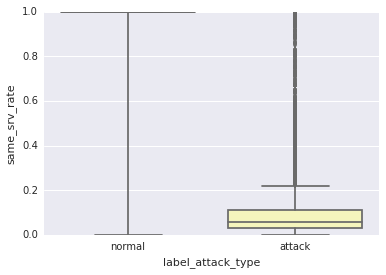

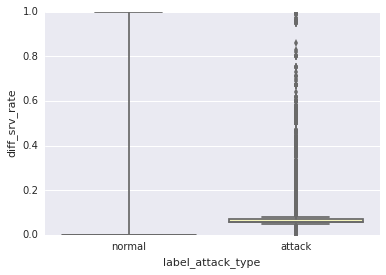

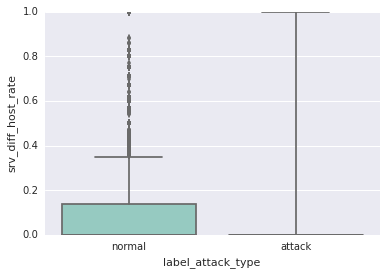

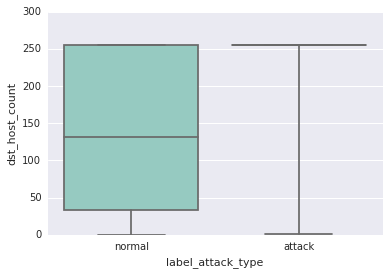

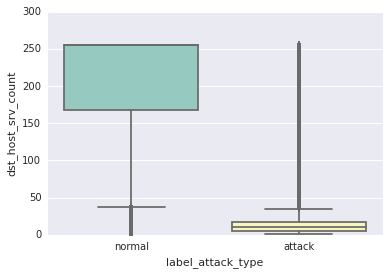

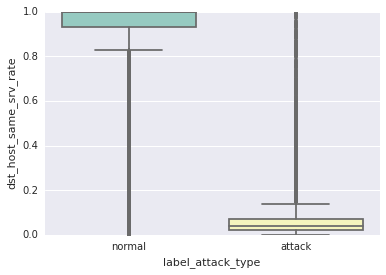

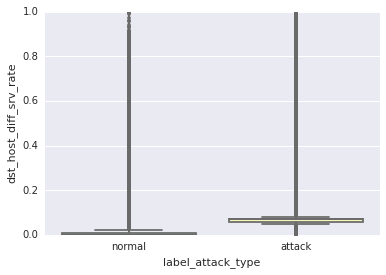

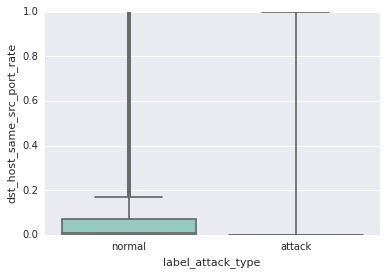

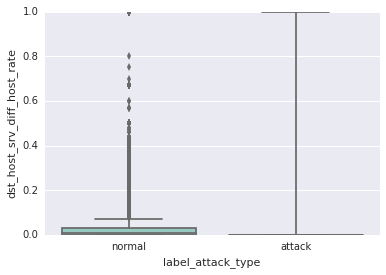

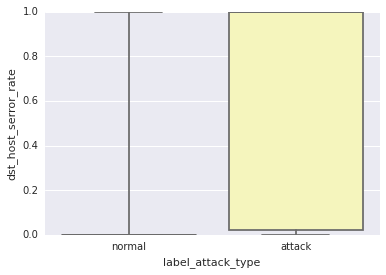

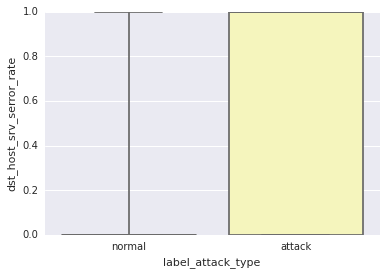

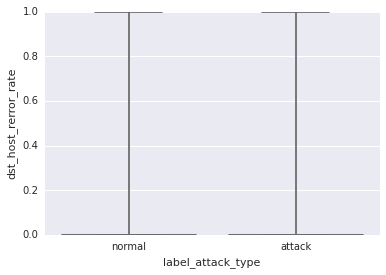

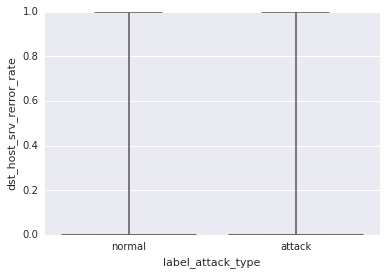

In [23]:
## Checking distributions of continuous variables with default_status by plotting boxplots
for column in raw_data.columns:
    if column not in categorical_cols+['index','service','label','label_attack_type']:
        plt.figure()
        sns.boxplot(x="label_attack_type", y=column,data=raw_data , palette = "Set3")

In [24]:
# converting label_attack_type to 0 and 1
raw_data.loc[raw_data['label_attack_type'] == 'normal', 'final_label'] = 0
raw_data.loc[raw_data['label_attack_type'] == 'attack', 'final_label'] = 1

In [25]:
#one hot encoding of categorical variables

flag_encoding = pd.get_dummies(raw_data['flag'],prefix = 'flag')
service_encoding = pd.get_dummies(raw_data['service'],prefix = 'service')
protocol_encoding = pd.get_dummies(raw_data['protocol_type'],prefix = 'protocol')

# concat with blm dataframe

raw_data = pd.concat([raw_data, flag_encoding,service_encoding,protocol_encoding], axis =1 )

In [26]:
raw_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,protocol_icmp,protocol_tcp,protocol_udp
0,0,tcp,http,SF,181,5450,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Stratified Sampling

In [27]:
# split into train and test datasets
#TODO : Add explanation for why we are removing these columns
predictors = [c for c in raw_data.columns if c not in ['label', 'label_attack_type', 'index', 'protocol_type',
                                                   'flag','service','is_host_login','final_label']]

X = raw_data[predictors]
y = raw_data['final_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3, stratify = y)

In [28]:
print(y_test.value_counts())

0    26350
1    17326
dtype: int64


In [29]:
print(y_train.value_counts())

0    61481
1    40428
dtype: int64


##### Evaluation function   
Metrics - Accuracy, precision, recall, F1 score, Confusion matrix, roc_auc 

In [41]:
def get_performance_metrics(y_test,model_predictions):
    # Accuracy
    model_accuracy = accuracy_score(y_test,model_predictions)
    print("Accuracy is ", model_accuracy)

    # precision, recall, f1 score
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test,model_predictions)
    print('Precision for each class is ', model_precision)
    print('Recall/sensitivity for each class is ', model_recall)
    print('F1 Score for each class is ', model_f1)

    # roc_auc
    model_roc_auc = roc_auc_score(y_test,model_predictions)
    print('AUC-ROC score is ', model_roc_auc)

    # confusion matrix
    model_confusion_matrix = confusion_matrix(y_test,model_predictions)
    print('confusion matrix is :-->')
    print(model_confusion_matrix)

### Naive Bayes

In [33]:
# create instance of Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB(priors=None)

In [34]:
#making predictions
nb_predictions = nb_model.predict(X_test)

In [35]:
get_performance_metrics(y_test,nb_predictions)

('Accuracy is ', 0.78835058155508742)
('Precision for each class is ', array([ 0.74101105,  0.99352711]))
('Recall/sensitivity for each class is ', array([ 0.99798861,  0.46952557]))
('F1 Score for each class is ', array([ 0.85051263,  0.63768911]))
('AUC-ROC score is ', 0.7337570916552566)
confusion matrix is :-->
[[26297    53]
 [ 9191  8135]]


### Logistic Regression

In [36]:
# create instance of logistic model

lr_model = LogisticRegression(random_state = 3)
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
# predictions
lr_predictions = lr_model.predict(X_test)

In [38]:
get_performance_metrics(y_test,lr_predictions)

('Accuracy is ', 0.96554171627438412)
('Precision for each class is ', array([ 0.95066207,  0.99099994]))
('Recall/sensitivity for each class is ', array([ 0.99449715,  0.92150525]))
('F1 Score for each class is ', array([ 0.97208569,  0.95498998]))
('AUC-ROC score is ', 0.95800120296114188)
confusion matrix is :-->
[[26297    53]
 [ 9191  8135]]


### Decision Tree

In [ ]:
#create instance of decision tree
dt_model = DecisionTreeClassifier(random_state = 3)
dt_model.fit(X_train, y_train)

In [27]:
# predictions
dt_predictions = dt_model.predict(X_test)

In [28]:
get_performance_metrics(y_test,dt_predictions)

Accuracy is  0.99942760326
Precision for each class is  [ 0.99896176  0.99973423]
Recall/sensitivity for each class is  [ 0.99959598  0.99931689]
F1 Score for each class is  [ 0.99927877  0.99952552]
AUC-ROC score is  0.999456435481
confusion matrix is :-->
[[17319     7]
 [   18 26332]]


### Random Forest Model

In [44]:
#create instance of random forest model
rf_model = RandomForestClassifier(n_estimators=500,n_jobs = -1, random_state=3)

In [45]:
# fitting data to random forest model
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [46]:
# predictions
rf_predictions = rf_model.predict(X_test)

In [47]:
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.99942760326037183)
('Precision for each class is ', array([ 0.99916569,  0.99982666]))
('Recall/sensitivity for each class is ', array([ 0.99988615,  0.99873023]))
('F1 Score for each class is ', array([ 0.99952579,  0.99927815]))
('AUC-ROC score is ', 0.99930819001441495)
confusion matrix is :-->
[[26347     3]
 [   22 17304]]


##### Hyperparameter tuning - using GridSearchCV

In [39]:
# choose set of parameters to tune
params = {  'C' : [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'], 
            'fit_intercept': [True, False]}

# create instance of GridSearch and fit the data
grid = GridSearchCV(estimator = lr_model, param_grid = params)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [40]:
# evaluate the best grid searched model on the testing data
grid_search_accuracy = grid.score(X_test, y_test)
print('Grid Search Accuracy is {0}'.format(grid_search_accuracy))
print("grid search best parameters: {}".format(grid.best_params_))

Grid Search Accuracy is 0.995924535214
grid search best parameters: {'penalty': 'l1', 'C': 10, 'fit_intercept': False}


## Balancing class data

### 1. Adjust the class weight (misclassification costs)

In [42]:
# Class weights can be cutomized in this format: class_weight={0: 100,1: 1} 
# Class weights can be given 'balanced': class_weight= 'balanced'

rf_model = RandomForestClassifier(n_estimators=500,n_jobs = -1, random_state=3, class_weight={0: 100,1: 1})
rf_model.fit(X_train,y_train)
rf_predictions = rf_model.predict(X_test)

In [43]:
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.99938181152120154)
('Precision for each class is ', array([ 0.99931712,  0.99948028]))
('Recall/sensitivity for each class is ', array([ 0.99965844,  0.9989611 ]))
('F1 Score for each class is ', array([ 0.99948775,  0.99922062]))
('AUC-ROC score is ', 0.99930977147461952)
confusion matrix is :-->
[[26341     9]
 [   18 17308]]


### Adjust the decision threshold

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8


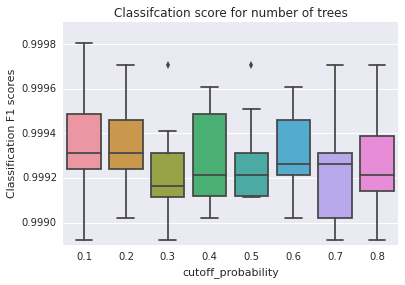

In [51]:
## Adjust the decision threshold of default value of 0.5 
## Finding threshold cutoff probability value 

def predict_label_given_cutoff(model,X_train,cutoff_prob):
    return (model.predict_proba(X_train)[:,1]>cutoff_prob)

scores = []
cutoff_prob_list = []

def f1_for_given_cutoff(cutoff_prob):
    def f1_cutoff(clf,X_train,y_train):
        y_predict = predict_label_given_cutoff(clf_rf,X_train,cutoff_prob)
        return sklearn.metric.f1_score(y_train,y_predict)

for cutoff_prob in np.arange(0.1,0.9,0.1):
    rf_model = RandomForestClassifier(n_estimators= 50,n_jobs = -1)
    lb = LabelBinarizer()
    y_train = np.array([number[0] for number in lb.fit_transform(y_train)])
    validated = cross_val_score(rf_model,X_train,y_train, cv=10, scoring =f1_for_given_cutoff(cutoff_prob))
    scores.append(validated)
    cutoff_prob_list.append(cutoff_prob)
    print(cutoff_prob)
    
sns.boxplot(cutoff_prob_list,scores)
plt.xlabel('cutoff_probability')
plt.ylabel('Classification F1 scores')
plt.title('Classifcation score for number of trees')
plt.show()

In [53]:
## Observed cutoff_prob from above graph 
cutoff_prob = 0.1

## Model 
rf_model = RandomForestClassifier(n_estimators= 50,n_jobs = -1)
rf_model.fit(X_train,y_train)

# predictions, for given cutoff prob value
rf_predictions = predict_label_given_cutoff(rf_model,X_test,cutoff_prob)

In [54]:
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.99812253869401957)
('Precision for each class is ', array([ 1.        ,  0.99528952]))
('Recall/sensitivity for each class is ', array([ 0.99688805,  1.        ]))
('F1 Score for each class is ', array([ 0.9984416,  0.9976392]))
('AUC-ROC score is ', 0.99844402277039856)
confusion matrix is :-->
[[26268    82]
 [    0 17326]]
